In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### install

In [ ]:
pip install biosppy wfdb hrv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spectrum: filename=spectrum-0.8.1-cp310-cp310-linux_x86_64.whl size=236597 sha256=2c80c6a560679ed276061e138df5d5d45864aa649abbca1e9cdea2f9a8174b27
  Stored in directory: /root/.cache/pip/wheels/e7/5a/09/ffc6afdf8a5a6f58e9851292108df32bb11374e11b8705cabd
  Created wheel for easydev: filename=easydev-0.12.1-py3-none-any.whl size=64213 sha256=27453af0df9314a6bab313acfee77066edb30d6c42961bf71b2ddaef417196f3
  Stored in directory: /root/.cache/pip/wheels/c5/a3/df/e8e19f6f1674c2b0574ccc1a156292b599709eaa4feeea0fcf
Successfully built spectrum easydev


In [ ]:
pip install spectrum

## HRV library  
https://github.com/rhenanbartels/hrv/tree/develop

### detrend

In [ ]:
#----------------------------------detrend-------------------------------------#

import numpy as np
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
from scipy.sparse import spdiags, dia_matrix


__all__ = ['polynomial_detrend', 'smoothness_priors', 'sg_detrend']


def polynomial_detrend(rri, degree=1):
    """
    Fits a polynomial function with degree=`degree` in the RRi series
    and then subtract it from the signal.

    Parameters
    ----------
    rri : array_like
        sequence containing the RRi series
    degree: integer, optional
        degree of the polynomial function to be fitted in the RRi series.
        Defaults to 1

    Returns
    -------
    results : RRi array
        instance of the RRi Detrended class containing the detrended RRi values

    See Also
    -------
    smoothness_priors, sg_detrend

    Examples
    --------
    >>> from hrv.detrend import polynomial_detrend
    >>> from hrv.sampledata import load_rest_rri
    >>> rri = load_rest_rri()
    >>> polynomial_detrend(rri)
    RRi array([ 5.60099763e+01,  5.50082903e+01, ..., 8.00667554e+00])
    """
    if isinstance(rri, RRi):
        time = rri.time
        rri = rri.values
    else:
        time = _create_time_array(rri)

    coef = np.polyfit(time, rri, deg=degree)
    polynomial = np.polyval(coef, time)
    detrended_rri = rri - polynomial
    return RRiDetrended(detrended_rri, time=time)


def smoothness_priors(rri, l=500, fs=4.0):
    """
    Estimates the stationary part of the resampled RRi series and subtracts it
    from the signal. The RRi series must have equal time-space between
    adjacents RRi values, therefore the original RRi is interpolated and then
    resampled.

    Parameters
    ----------
    rri : array_like
        sequence containing the RRi series
    l: integer, optional
        the regularization parameter
        Defaults to 500
    fs: integer, optional
        sampling frequency in each the RRi series will be resampled after
        cubic interpolation. Defaults to 4

    .. math::
        The estimated stationary component of the RRi can represented as:
        z_stat = (I - (l**2 @ D2.T @ D2)**2) @ z

        where I is the identity matrix; D2 is the second order difference
        matrix and z is the evenly spaced RRi series (containing both
        stationaty and trend components)

    Returns
    -------
    results : RRi array
        instance of the RRi Detrended class containing the detrended RRi values

    See Also
    -------
    polynomial_detrend, sg_detrend

    References
    ----------
    - M.P.  Tarvainen,  P.O.  Ranta-aho  and  P.A.  Karjalainen,  An  advanced
      detrending  method  with  application  to  HRV  analysis, IEEE
      Transaction on Biomedical Engineering 49 (2002), 172–175.

    Examples
    --------
    >>> from hrv.detrend import smoothness_priors
    >>> from hrv.sampledata import load_rest_rri
    >>> rri = load_rest_rri()
    >>> smoothness_priors(rri)
    RRi array([27.17281349,   46.12837695,   51.21922892, ..., 1042.86845282])
    """
    if isinstance(rri, RRi):
        time = rri.time
        rri = rri.values
    else:
        time = _create_time_array(rri)

    # TODO: only interp if not interpolated yet
    cubic_spline = CubicSpline(time, rri)
    time_interp = np.arange(time[0], time[-1], 1.0 / fs)
    rri_interp = cubic_spline(time_interp)
    N = len(rri_interp)
    identity = np.eye(N)
    B = np.dot(np.ones((N - 2, 1)), np.array([[1, -2, 1]]))
    D_2 = dia_matrix((B.T, [0, 1, 2]), shape=(N - 2, N))
    inv = np.linalg.inv(identity + l ** 2 * D_2.T @ D_2)
    z_stat = ((identity - np.linalg.inv(identity + l ** 2 * D_2.T @ D_2))) @ rri_interp

    rri_interp_detrend = np.squeeze(np.asarray(rri_interp - z_stat))
    return RRiDetrended(
        rri_interp - rri_interp_detrend,
        time=time_interp,
        detrended=True,
        interpolated=True,
    )


def sg_detrend(rri, window_length=51, polyorder=3, *args, **kwargs):
    """
    Remove the low-frequency components of the RRi series with the low-pass
    filter developed by Savitzky-Golay

    Parameters
    ----------
    rri : array_like
        sequence containing the RRi series
    window_length: integer, optional
        The length of the filter window (i.e. the number of coefficients).
        `window_length` must be a positive odd integer. If `mode` is 'interp',
        `window_length` must be less than or equal to the size of `x`.
        Defaults to 51
    polyorder: integer, optional
        The order of the polynomial used to fit the samples.  `polyorder` must
        be less than `window_length`. Defauts to 3

    See scipy.signal.savgol_filter for more information

    Returns
    -------
    results : RRi array
        instance of the RRi Detrended class containing the detrended RRi values

    See Also
    -------
    polynomial_detrend, smoothness_priors

    Examples
    --------
    >>> from hrv.detrend import sg_detrend
    >>> from hrv.sampledata import load_rest_rri
    >>> rri = load_rest_rri()
    >>> sg_detrend(rri)
    RRi array([5.07722695e+01, 4.16090643e+01, ..., -1.26297542e+01])
    """
    if isinstance(rri, RRi):
        time = rri.time
        rri = rri.values
    else:
        time = _create_time_array(rri)

    trend = savgol_filter(
        rri, window_length=window_length, polyorder=polyorder, *args, **kwargs
    )
    return RRiDetrended(rri - trend, time=time, detrended=True)

### utils

In [ ]:
#----------------------------------utils-------------------------------------#

from functools import wraps
from numbers import Number

import numpy as np
from scipy import interpolate

# TODO: Remove unused functions


# def _identify_rri_file_type(file_content):
#     is_hrm_file = file_content.find('[HRData]')
#     if is_hrm_file >= 0:
#         file_type = 'hrm'
#     else:
#         rri_lines = file_content.split('\n')
#         for line in rri_lines:
#             current_line_number = re.findall(r'\d+', line)
#             if current_line_number:
#                 if not current_line_number[0] == line.strip():
#                     raise FileNotSupportedError('Text file not supported')
#         file_type = 'text'
#     return file_type


# TODO: Refactor validation decorator
def validate_rri(func):
    @wraps(func)
    def _validate(rri, *args, **kwargs):
        _validate_positive_numbers(rri)
        rri = _transform_rri(rri)
        return func(rri, *args, **kwargs)

    def _validate_positive_numbers(rri):
        if not all(map(lambda value: isinstance(value, Number) and value > 0, rri)):
            raise ValueError(
                "rri must be a list or numpy.ndarray of positive"
                " and non-zero numbers"
            )

    return _validate


def _transform_rri(rri):
    return _transform_rri_to_miliseconds(np.array(rri))


# TODO: Refactor validation decorator
def validate_frequency_domain_arguments(func):
    def _check_frequency_domain_arguments(
        rri, fs=4.0, method="welch", interp_method="cubic", **kwargs
    ):
        _validate_available_methods(method)
        return func(rri, fs, method, interp_method, **kwargs)

    def _validate_available_methods(method):
        available_methods = ("welch", "ar")
        if method not in available_methods:
            raise ValueError(
                "Method not supported! Choose among: {}".format(
                    ", ".join(available_methods)
                )
            )

    return _check_frequency_domain_arguments


def _create_time_info(rri):
    rri_time = np.cumsum(rri) / 1000.0  # make it seconds
    return rri_time - rri_time[0]  # force it to start at zero


def _transform_rri_to_miliseconds(rri):
    if np.median(rri) < 1:
        rri *= 1000
    return rri


def _interpolate_rri(rri, time, fs=4, interp_method="cubic"):
    if interp_method == "cubic":
        return _interp_cubic_spline(rri, time, fs)
    elif interp_method == "linear":
        return _interp_linear(rri, time, fs)


def _interp_cubic_spline(rri, time, fs):
    time_rri_interp = _create_interp_time(time, fs)
    tck = interpolate.splrep(time, rri, s=0)
    rri_interp = interpolate.splev(time_rri_interp, tck, der=0)
    return rri_interp


def _interp_linear(rri, time, fs):
    time_rri_interp = _create_interp_time(time, fs)
    rri_interp = np.interp(time_rri_interp, time, rri)
    return rri_interp


def _create_interp_time(time, fs):
    time_resolution = 1 / float(fs)
    return np.arange(0, time[-1] + time_resolution, time_resolution)


def _ellipsedraw(ax, a, b, x0, y0, phi, *args, **kwargs):
    theta = np.arange(-0.03, 2 * np.pi, 0.01)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    X = np.cos(phi) * x - np.sin(phi) * y
    Y = np.sin(phi) * x + np.cos(phi) * y

    X = X + x0
    Y = Y + y0

    ax.plot(X, Y, *args, **kwargs)
    return ax

In [ ]:
#--------------------------------------RRI------------------------------------------#

"""
Objects for dealing with RR intervals series (RRi).

This module offers two classes to represent RRi series as Python objects which
brings widely used methods to extract information from tachograms.
Once RRi or RRiDetrended are instanciated is it possible to calculate simple
descriptive statistics of the RRi series, such: average, median, etc. It is
also possible to visualize the series with the plot method, extract a smaller
segment of the RRi series based on time information

Classes
------
 - `RRi` -- RRi series class
 - `RRiDetrended` -- detrended RRi values
"""

import sys
from collections.abc import MutableMapping
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np



__all__ = ['RRi', 'RRiDetrended']


class RRi:
    """An RRi series class.

       The RRi class provides magic methods that make it instance behave like
       a Python iterable. It also has methods that help to describe the
       statistical properties of the instantiated RRi series and for
       visualization purpose.

       This class performs simple validation of the provided rri values:
            - it can not have negative values
            - if the median values are smaller than 10, it is presumed they
              are in seconds and are transformed into miliseconds
       If time information, which is optional, is provided it is also
       validated:
            - time array must have the same length as the RRi series
            - must be monotonically increasing
            - no negative values
            - only the first value can be zero

        When time information is not provided it will be created with the
        cumulative sum of the RRi values:
            time = np.cumsum(rri) / 1000.0
            time -= time[0]  # to start at zero

        Time is represented in seconds
    """

    def __init__(self, rri, time=None, *args, **kwargs):
        if not isinstance(self, RRiDetrended):
            self.__rri = _validate_rri(rri)
            self.__detrended = False
            self.__interpolated = False
        else:
            self.__rri = np.array(rri)
            self.__detrended = kwargs.pop("detrended")
            self.__interpolated = kwargs.pop("interpolated", False)

        if time is None:
            self.__time = _create_time_array(self.rri)
        else:
            self.__time = _validate_time(self.__rri, time)

    def __len__(self):
        return len(self.__rri)

    def __getitem__(self, position):
        if isinstance(position, (slice, np.ndarray)):
            return RRi(self.__rri[position], self.time[position])
        else:
            return self.__rri[position]

    @property
    def values(self):
        """Return a numpy array containing the RRi values"""
        return self.__rri

    @property
    def rri(self):
        """Return a numpy array containing the RRi values"""
        return self.__rri

    @property
    def time(self):
        """Return a numpy array containing the time information"""
        return self.__time

    @property
    def detrended(self):
        """Return if the RRi series is detrended"""
        return self.__detrended

    @property
    def interpolated(self):
        """Return if the RRi series is interpolated"""
        return self.__interpolated

    def describe(self):
        """
        Return a dictionary containing descriptive statistics from the RRi
        series.
        """
        table = _prepare_table(RRi(self.rri))
        rri_descr = RRiDescription(table)
        for row in table[1:]:
            rri_descr[row[0]]["rri"] = row[1]
            rri_descr[row[0]]["hr"] = row[2]

        return rri_descr

    def info(self):
        """
        Print information about RRi`s memory usage, length,
        number of intervals, and if it is interpolated and/or detrended
        """

        def _mem_usage(nbytes):
            mem_val = nbytes / 1024
            if mem_val < 1000:
                mem_str = "{:.2f}Kb".format(mem_val)
            else:
                mem_str = "{:.2f}Mb".format(mem_val / 1024)

            return mem_str

        n_points = self.__rri.size
        duration = self.__time[-1] - self.__time[0]
        # Hard coded interp and detrended. Future versions will have proper
        # attributes
        mem_usage = _mem_usage(self.__rri.nbytes)

        msg_template = (
            "N Points: {n_points}\nDuration: {duration:.2f}s\n"
            "Interpolated: {interp}\nDetrended: {detrended}\n"
            "Memory Usage: {mem_usage}"
        )
        sys.stdout.write(
            msg_template.format(
                n_points=n_points,
                duration=duration,
                interp=self.interpolated,
                detrended=self.detrended,
                mem_usage=mem_usage,
            )
        )

    def to_hr(self):
        """
        Return a numpy array containing the heart rate calculated with
        the RRi series
        """
        return 60 / (self.rri / 1000.0)

    def time_range(self, start, end):
        """
        Crop the RRi series based in time information

        Parameters
        ----------
        start : float
            beginning of the new RRi series

        end : float
            end of the new RRi series
        """
        interval = np.logical_and(self.time >= start, self.time <= end)
        return RRi(self.rri[interval], time=self.time[interval])

    def reset_time(self, inplace=False):
        """
        Reset time information to force it starting from zero

        Parameters
        ----------
        inplace : boolean, default False
            If true, time information of the current RRi series will be reset
        """
        if inplace:
            self.__time -= self.time[0]
        else:
            return RRi(self.rri, time=self.time - self.time[0])

    def plot(self, ax=None, *args, **kwargs):
        """
        Plot RRi series

        Parameters
        ----------
        ax : matplotlib axes object, default None
        """
        fig = None
        if ax is None:
            fig, ax = plt.subplots(1, 1)

        ax.plot(self.time, self.rri, *args, **kwargs)
        ax.set(xlabel="Time (s)", ylabel="RRi (ms)")
        plt.show(block=False)

        return fig, ax

    def hist(self, hr=False, *args, **kwargs):
        """
        Plot the histogram of the RRi series

        Parameters
        ----------
        hr : boolean, optional
            If true, the histogram of the heart rate is depicted
        """
        fig, ax = plt.subplots(1, 1)
        if hr:
            ax.hist(self.to_hr(), *args, **kwargs)
            ax.set(xlabel="HR (bpm)", ylabel="Frequency")
        else:
            ax.hist(self.rri, *args, **kwargs)
            ax.set(xlabel="RRi (ms)", ylabel="Frequency")

        plt.show(block=False)

        return fig, ax

    def poincare_plot(self):
        """
        Poincaré plot of the RRi series
        """
        fig, ax = plt.subplots(1, 1)
        rri_n, rri_n_1 = self.rri[:-1], self.rri[1:]
        ax.plot(rri_n, rri_n_1, ".k")

        ax.set(xlabel="$RRi_n$ (ms)", ylabel="$RRi_{n+1}$ (ms)", title="Poincaré Plot")

        plt.show(block=False)

        # The ellipse drawning is a translation from the Matlab code
        # available at: https://github.com/jramshur/HRVAS

        dx = abs(max(rri_n) - min(rri_n)) * 0.05
        dy = abs(max(rri_n_1) - min(rri_n_1)) * 0.05
        xlim = [min(rri_n) - dx, max(rri_n) + dx]
        ylim = [min(rri_n_1) - dy, max(rri_n_1) + dy]

        from hrv.classical import non_linear

        nl = non_linear(self.rri)
        a = rri_n / np.cos(np.pi / 4.0)
        ca = np.mean(a)

        cx, cy, _ = ca * np.cos(np.pi / 4.0), ca * np.sin(np.pi / 4.0), 0

        width = nl["sd2"]  # to seconds
        height = nl["sd1"]  # to seconds

        # plot fx(x) = x
        sd2_l = ax.plot(
            [xlim[0], xlim[1]], [ylim[0], ylim[1]], "--", color=[0.5, 0.5, 0.5]
        )
        fx = lambda val: -val + 2 * cx

        sd1_l = ax.plot([xlim[0], xlim[1]], [fx(xlim[0]), fx(xlim[1])], "k--")
        ax = _ellipsedraw(
            ax, width, height, cx, cy, np.pi / 4.0, color="r", linewidth=3
        )
        ax.legend(
            (sd1_l[0], sd2_l[0]), ("SD1: %.2fms" % height, "SD2: %.2fms" % width),
        )

        return fig, ax

    # TODO: Create methods for time domain to be calculted in the instance

    def mean(self, *args, **kwargs):
        """Return the average of the RRi series"""
        return np.mean(self.rri, *args, **kwargs)

    def var(self, *args, **kwargs):
        """Return the variance of the RRi series"""
        return np.var(self.rri, *args, **kwargs)

    def std(self, *args, **kwargs):
        """Return the standard deviation of the RRi series"""
        return np.std(self.rri, *args, **kwargs)

    def median(self, *args, **kwargs):
        """Return the median of the RRi series"""
        return np.median(self.rri, *args, **kwargs)

    def max(self, *args, **kwargs):
        """Return the max value of the RRi series"""
        return np.max(self.rri, *args, **kwargs)

    def min(self, *args, **kwargs):
        """Return the min value of the RRi series"""
        return np.min(self.rri, *args, **kwargs)

    def amplitude(self):
        """Return the amplitude (max - min) of the RRi series"""
        return self.max() - self.min()

    def rms(self):
        """Return the root mean squared of the RRi series"""
        return np.sqrt(np.mean(self.rri ** 2))

    def time_split(self, seg_size, overlap=0, keep_last=False):
        """
        Splits the RRi series in smaller segments with approximately
        the same time duration.

        Parameters
        ----------
        seg_size : Number
            The segment size in seconds
        overlap : Number, optional
            The size of overlap between adjacents segments, defaults to 0
        keep_last : boolean, optional
            If set to True the last segment is returned even if smaller than
            `seg_size`, defaults to False
        """
        rri_duration = self.time[-1]
        if overlap > seg_size:
            raise Exception("`overlap` can not be bigger than `seg_size`")
        elif seg_size > rri_duration:
            raise Exception("`seg_size` is longer than RRi duration.")

        begin = 0
        end = seg_size
        step = seg_size - overlap
        n_splits = int((rri_duration - seg_size) / step) + 1
        segments = []
        for i in range(n_splits):
            OP = np.less if i + 1 != n_splits else np.less_equal
            mask = np.logical_and(self.time >= begin, OP(self.time, end))
            segments.append(RRi(self.rri[mask], time=self.time[mask]))
            begin += step
            end += step

        last = segments[-1]
        if keep_last and last.time[-1] < rri_duration:
            mask = self.time > begin
            segments.append(RRi(self.rri[mask], time=self.time[mask]))

        return segments

    def __repr__(self):
        return "RRi %s" % np.array_repr(self.rri)

    def __mul__(self, val):
        return RRi(self.rri * val, self.time)

    def __add__(self, val):
        return RRi(self.rri + val, self.time)

    def __sub__(self, val):
        return RRi(self.rri - val, self.time)

    def __truediv__(self, val):
        return RRi(self.rri / val, self.time)

    def __pow__(self, val):
        return RRi(self.rri ** val, self.time)

    def __abs__(self):
        return RRi(np.abs(self.rri), self.time)

    def __eq__(self, val):
        return self.rri == val

    def __ne__(self, val):
        return self.rri != val

    def __gt__(self, val):
        return self.rri > val

    def __ge__(self, val):
        return self.rri >= val

    def __lt__(self, val):
        return self.rri < val

    def __le__(self, val):
        return self.rri <= val


class RRiDetrended(RRi):
    # TODO: add trend as attribute of the instance
    def __init__(self, rri, time, *args, **kwargs):
        detrended = True
        interpolated = kwargs.pop("interpolated", False)
        super().__init__(rri, time, interpolated=interpolated, detrended=detrended)


class RRiDescription(MutableMapping):
    def __init__(self, table, *args, **kwargs):
        self.store = defaultdict(dict)
        self.update(dict(*args, **kwargs))
        self.table = table

    def keys(self):
        return self.store.keys()

    def __getitem__(self, key):
        return self.store[key]

    def __setitem__(self, key, value):
        self.store[key] = value

    def __delitem__(self, key):
        del self.store[key]

    def __iter__(self):
        return iter(self.store)

    def __len__(self):
        return len(self.store)

    def __repr__(self):
        descr = ""
        dash = "-" * 40 + "\n"
        for i in range(len(self.table)):
            if i == 0:
                descr += dash
                descr += "{:<10s}{:>12s}{:>12s}\n".format(
                    self.table[i][0], self.table[i][1], self.table[i][2]
                )
                descr += dash
            else:
                descr += "{:<10s}{:>12.2f}{:>12.2f}\n".format(
                    self.table[i][0], self.table[i][1], self.table[i][2]
                )

        return descr


def _prepare_table(rri):
    def _amplitude(values):
        return values.max() - values.min()

    header = ["", "rri", "hr"]
    fields = ["min", "max", "mean", "var", "std"]
    hr = rri.to_hr()

    table = []
    for field in fields:
        rri_var = rri.__getattribute__(field)()
        hr_var = hr.__getattribute__(field)()
        table.append([field, rri_var, hr_var])

    table.append(["median", rri.median(), np.median(hr)])
    table.append(["amplitude", rri.amplitude(), _amplitude(hr)])

    return [header] + table


def _validate_rri(rri):
    # TODO: let the RRi be in seconds if the user wants to
    rri = np.array(rri, dtype=np.float64)

    if any(rri <= 0):
        raise ValueError("rri series can only have positive values")

    # Use RRi series median value to check if it is in seconds or miliseconds
    if np.median(rri) < 10:
        rri *= 1000.0

    return rri


def _validate_time(rri, time):
    time = np.array(time, dtype=np.float64)
    if len(rri) != len(time):
        raise ValueError("rri and time series must have the same length")

    if any(time[1:] == 0):
        raise ValueError("time series cannot have 0 values after first position")

    if not all(np.diff(time) > 0):
        raise ValueError("time series must be monotonically increasing")

    if any(time < 0):
        raise ValueError("time series cannot have negative values")

    return time


def _create_time_array(rri):
    time = np.cumsum(rri) / 1000.0
    return time - time[0]

### classical

In [ ]:
#-----------------------------classical-----------------------------#

import numpy as np

from scipy.signal import welch
from spectrum import pburg

from collections.abc import MutableMapping
from collections import defaultdict


__all__ = ['time_domain', 'frequency_domain', 'non_linear']


# validate_rri
def time_domain(rri):
    """
    time_domain(rri)

    Calculate time-domain indices from an RRi series

    Parameters
    ----------
    rri : array_like
        sequence containing the RRi series

    Returns
    -------
    results : dict
        Dictionary containing the following time domain indices:
            - RMSSD: root mean squared of the successive differences
            - SDNN: standard deviation of the RRi series
            - SDSD: standard deviation of the successive differences
            - NN50: number RRi successive differences greater than 50ms
            - PNN50: percentage of RRi successive differences greater than 50ms
            - MRI: average value of the RRi series
            - MHR: average value of the heart rate calculated from the
                   RRi sries

    References
    ----------
    - Heart rate variability. (1996). Standards of measurement, physiological
      interpretation, and clinical use. Task Force of the European Society of
      Cardiology and the North American Society of Pacing and
      Electrophysiology. Eur Heart J, 17, 354-381.

    Examples
    --------
    >>> from hrv.classical import time_domain
    >>> from hrv.sampledata import load_rest_rri
    >>> rri = load_rest_rri()
    >>> time_domain(rri)
    {'rmssd': 55.13744203126742,
     'sdnn': 57.81817771970009,
     'sdsd': 55.167700730663555,
     'nn50': 321,
     'pnn50': 35.27472527472528,
     'mrri': 1058.7186813186813,
     'mhr': 56.85278105637358}
    """
    # TODO: let user choose interval for pnn50 and nn50.
    diff_rri = np.diff(rri)
    rmssd = np.sqrt(np.mean(diff_rri ** 2))
    sdnn = np.std(rri, ddof=1)  # make it calculates N-1
    sdsd = np.std(diff_rri, ddof=1)
    nn50 = _nn50(rri)
    pnn50 = _pnn50(rri)
    mrri = np.mean(rri)
    mhr = np.mean(60 / (rri / 1000.0))

    return dict(
        zip(
            ["rmssd", "sdnn", "sdsd", "nn50", "pnn50", "mrri", "mhr"],
            [rmssd, sdnn, sdsd, nn50, pnn50, mrri, mhr],
        )
    )


def _nn50(rri):
    return sum(abs(np.diff(rri)) > 50)


def _pnn50(rri):
    return _nn50(rri) / len(rri) * 100


# TODO: create nperseg, noverlap, order, nfft, and detrend arguments
def frequency_domain(
    rri,
    time=None,
    fs=4.0,
    method="welch",
    interp_method="cubic",
    detrend="constant",
    vlf_band=(0, 0.04),
    lf_band=(0.04, 0.15),
    hf_band=(0.15, 0.4),
    **kwargs
):
    """
    Estimate the Power Spectral Density (PSD) of an RRi series and
    calculate the area under the curve (AUC) of the Very Low, Low, and High
    frequency bands. The PSD can be estimated using non-parametric
    (FFT - Welch's method) or parametric (Autoregressive - Burg's method)
    approaches. The AUC is calculated using the trapezoidal method
    (numpy.trapz).

    Parameters
    ----------
    rri : array_like
        Sequence containing the RRi series
    time : array_like, optional
        Sequence containing the time associated with the RRi series.
        When not provided time is created from the cumulative sum of the
        values from the RRi series
    method : str, optional
        The method for Power Spectral Density estimation. 'welch' (default),
        'ar' (spectrum, see Cokelaer et al., 2017)
    interp_method : str {'cubic', 'linear'}, optional
        Interpolation funtion applied to the RRi series. If RRi series
        is already interpolated this step is skipped. 'cubic' (default),
        'linear'
    nperseg : int, optional
        The size of each segment used in the FFT-based estimation of the PSD.
        Defaults to 256. ``nperseg <= len(rri)``. See scipy.signal.welch
        for more information
    noverlap : int, optional
        The size of overlap between each adjacent rri segments. If `None`
        ``noverlap = nperseg // 2``. See scipy.signal.welch for more
        information
    detrend : str or function, optional
        Detrend method applied to the RRi series. Defaults to 'constant'.
        If the rri is an RRiDetrend object this step is skipped.
        See scipy.signal.welch for more information
    window : str or tuple or array_like, optional
        Window function applied to each segment of the RRi series to avoid
        spectral leakage. Only applied when welch method is chosen.
        Defaults to Hanning. See scipy.signal.welch for more information
    order : int, optional
        Order of the Autoregressive model. Only applied when method is 'ar'.
        Defaults to 16
    vlf_band : tuple (inferior_bound, superior_bound), optional
        Frenquency interval of the Very Low frequency components of the
        estimated PSD. Defaults to (0, 0.04)
    lf_band : tuple (inferior_bound, superior_bound), optional
        Frenquency interval of the Low frequency components of the estimated
        PSD. Defaults to (0.04, 0.15)
    hf_band : tuple (inferior_bound, superior_bound), optional
        Frenquency interval of the High frequency components of the estimated
        PSD. Defaults to (0.15, 0.4)

    Returns
    -------
    results : dict
        Dictionary containing the following frequency domain indices:
            - Total Power: total energy of the PSD
            - VLF: energy associated with the Very Low frequency components
            - LF: energy associated with the Low frequency components
            - HF: energy associated with the High frequency components
            - LF/HF: ratio between lf and hf indices
            - LFnu: LF indice normalized by the Total Power. See math below
            - HFnu: HF indice normalized by the Total Power. See math below
                    RRi sries

    .. math::

        LFnu = LF / (Total Power - VLF)
        HFnu = HF / (Total Power - VLF)

    References
    ----------
    - Heart rate variability. (1996). Standards of measurement, physiological
      interpretation, and clinical use. Task Force of the European Society of
      Cardiology and the North American Society of Pacing and
      Electrophysiology. Eur Heart J, 17, 354-381.
    - Cokelaer et al., (2017). ‘Spectrum’: Spectral Analysis in Python.
      Journal of Open Source Software, 2(18), 348, doi:10.21105/joss.00348

    Examples
    --------
    >>> from hrv.classical import frequency_domain
    >>> from hrv.sampledata import load_rest_rri
    >>> rri = load_rest_rri()
    >>> frequency_domain(rri)
    {'total_power': 2212.2894012201778,
     'vlf': 546.8173917540497,
     'lf': 770.4465329950162,
     'hf': 895.0254764711116,
     'lf_hf': 0.8608096118478296,
     'lfnu': 46.25995084972849,
     'hfnu': 53.740049150271496}
    """

    if isinstance(rri, RRi):
        time = rri.time if time is None else time
        detrend = detrend if not rri.detrended else False
        interp_method = interp_method if not rri.interpolated else None

    if interp_method is not None:
        rri = _interpolate_rri(rri, time, fs, interp_method)

    if method == "welch":
        fxx, pxx = welch(x=rri, fs=fs, detrend=detrend, **kwargs)
    elif method == "ar":
        if detrend:
            rri = polynomial_detrend(rri, degree=1)
        fxx, pxx = _calc_pburg_psd(rri=rri, fs=fs, **kwargs)

    return _auc(fxx, pxx, vlf_band, lf_band, hf_band)


def _auc(fxx, pxx, vlf_band, lf_band, hf_band):
    vlf_indexes = np.logical_and(fxx >= vlf_band[0], fxx < vlf_band[1])
    lf_indexes = np.logical_and(fxx >= lf_band[0], fxx < lf_band[1])
    hf_indexes = np.logical_and(fxx >= hf_band[0], fxx < hf_band[1])

    vlf = np.trapz(y=pxx[vlf_indexes], x=fxx[vlf_indexes])
    lf = np.trapz(y=pxx[lf_indexes], x=fxx[lf_indexes])
    hf = np.trapz(y=pxx[hf_indexes], x=fxx[hf_indexes])
    total_power = vlf + lf + hf
    lf_hf = lf / hf
    lfnu = (lf / (total_power - vlf)) * 100
    hfnu = (hf / (total_power - vlf)) * 100

    return dict(
        zip(
            ["total_power", "vlf", "lf", "hf", "lf_hf", "lfnu", "hfnu"],
            [total_power, vlf, lf, hf, lf_hf, lfnu, hfnu],
        )
    )


def _calc_pburg_psd(rri, fs, order=16, nfft=None):
    burg = pburg(data=rri, order=order, NFFT=nfft, sampling=fs)
    burg.scale_by_freq = False
    burg()
    return np.array(burg.frequencies()), burg.psd


# validate_rri
def non_linear(rri):
    """
    Calculate non-linear indices from RRi series. So far, only SD1 and SD2
    features derived from the Poincaré analysis are available.

    Parameters
    ----------
    rri : array_like
        Sequence containing the RRi series

    Returns
    -------
    results : dict
        Dictionary containing the following non-linear indices:
            - SD1: standard deviation of the points in the Poincaré's plot
              projected in the y = x axis.
            - SD2: standard deviation of the points in the Poincaré's plot
              projected in the y = -x + mrri axis, where mrri is the average
              value of the RRi series.

    .. math::

        SD1 = np.sqrt(0.5 * np.std(np.diff(rri, ddof=1))**2)
        SD2 = np.sqrt(2 * np.std(rri, ddof=1) ** 2 - 0.5
              * np.std(np.diff(rri, ddof=1))**2)

    References
    ----------
    - Heart rate variability. (1996). Standards of measurement, physiological
      interpretation, and clinical use. Task Force of the European Society of
      Cardiology and the North American Society of Pacing and
      Electrophysiology. Eur Heart J, 17, 354-381.

    Examples
    --------
    >>> from hrv.classical import non_linear
    >>> from hrv.sampledata import load_rest_rri
    >>> rri = load_rest_rri()
    >>> non_linear(rri)
    {'sd1': 39.00945528912225, 'sd2': 71.86199098062633}
    """
    sd1, sd2 = _poincare(rri)
    return dict(zip(["sd1", "sd2"], [sd1, sd2]))


def _poincare(rri):
    diff_rri = np.diff(rri)
    sd1 = np.sqrt(np.std(diff_rri, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(rri, ddof=1) ** 2 - 0.5 * np.std(diff_rri, ddof=1) ** 2)
    return sd1, sd2

## Feature Extraction Func

In [ ]:
import os
import pickle
import sys
import warnings
from collections import OrderedDict
import biosppy.signals.tools as st
import numpy as np
import pandas as pd
import wfdb
from biosppy.signals.ecg import correct_rpeaks, hamilton_segmenter
# from hrv.classical import frequency_domain, time_domain
from scipy.signal import medfilt
from tqdm import tqdm

warnings.filterwarnings(action="ignore")

In [ ]:
base_dir = "/ecg_data/"

fs = 100  # 심전도 sampling rate
hr_min = 20   # 최소 심박수
hr_max = 300   # 최대 심박수
before = 2    # 예측할 시점 전 2분
after = 2     # 예측할 시점 후 2분
sample = fs * 60

In [ ]:
def feature_extraction(recording, signal, labels):
    data = []

    #------------label 개수만큼 반복 (분)------------
    for i in tqdm(range(len(labels)), desc=recording, file=sys.stdout):     # ex. 492

        if i < before or (i + 1 + after) > len(signal) / float(sample): continue

        segment = signal[int((i - before) * sample):int((i + 1 + after) * sample)]         # 총 5분 동안의 모든 signal 값을 가져옴

        #--------------필터처리---------------
        # FIR band pass filter를 사용하여 튀는 주파수 신호 제거 (3Hz~45Hz까지만 남김)
        segment, _, _ = st.filter_signal(segment, ftype='FIR', band='bandpass', order=int(0.3 * fs), frequency=[3, 45],
                                         sampling_rate=fs)

        #-----------Finding R peaks-----------
        rpeaks, = hamilton_segmenter(segment, sampling_rate=fs)     # segment 안에서 r peak 찾기
        rpeaks, = correct_rpeaks(segment, rpeaks, sampling_rate=fs, tol=0.1)      # r peak 위치 보정 (더 정확한 위치 반환)


        #--------------Extracting feature------------
        label = 0 if labels[i] == "N" else 1      # label 0/1로 다시 인코딩

        if (len(rpeaks) / (1 + after + before) < 40) or (len(rpeaks) / (1 + after + before) > 200):  continue

        rri_tm, rri = rpeaks[1:] / float(fs), np.diff(rpeaks, axis=-1) / float(fs)    # r peak의 시간차이, 값 차이
        rri = medfilt(rri, kernel_size=3)
        edr_tm, edr = rpeaks / float(fs), segment[rpeaks]     # rpeak 시간이랑 rpeak에서의 ecg 값

        # Remove physiologically impossible HR signal
        # 비정상 심박수 제거 (hr_min보다 작거나 hr_max보다 큰 경우 제거)
        if np.all(np.logical_and(60 / rri >= hr_min, 60 / rri <= hr_max)):
            # 시간 도메인, 주파수 도메인, edr, non_linear 변수 생성
            rri_time_features, rri_frequency_features = time_domain(rri * 1000), frequency_domain(rri, rri_tm)
            rri_non_linear = non_linear(rri * 1000)
            edr_frequency_features = frequency_domain(edr, edr_tm)

            # 총 21개의 feature 생성
            data.append([
                rri_time_features["rmssd"], rri_time_features["sdnn"], rri_time_features["nn50"], rri_time_features['sdsd'],
                rri_time_features["pnn50"], rri_time_features["mrri"], rri_time_features["mhr"],
                rri_frequency_features["vlf"] / rri_frequency_features["total_power"],
                rri_frequency_features["lf"] / rri_frequency_features["total_power"],
                rri_frequency_features["hf"] / rri_frequency_features["total_power"],
                rri_frequency_features["lf_hf"], rri_frequency_features["lfnu"], rri_frequency_features["hfnu"],
                edr_frequency_features["vlf"] / edr_frequency_features["total_power"],
                edr_frequency_features["lf"] / edr_frequency_features["total_power"],
                edr_frequency_features["hf"] / edr_frequency_features["total_power"],
                edr_frequency_features["lf_hf"], edr_frequency_features["lfnu"], edr_frequency_features["hfnu"],
                rri_non_linear['sd1'], rri_non_linear['sd2'],
                label
            ])
    data = np.array(data, dtype="float")
    return data


if __name__ == "__main__":
    apnea_ecg = OrderedDict()
    apnea_ecg_test = OrderedDict()


    #--------------train data--------------
    recordings = [
        "a01", "a02", "a03", "a04", "a05", "a06", "a07", "a08", "a09", "a10",
        "a11", "a12", "a13", "a14", "a15", "a16", "a17", "a18", "a19", "a20",
        "b01", "b02", "b03", "b04", "b05",
        "c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10"

    ]
    # train 데이터의 ECG signal과 label 읽어오기
    for recording in recordings:
        signal = wfdb.rdrecord(os.path.join(base_dir, recording), channels=[0]).p_signal[:, 0]
        labels = wfdb.rdann(os.path.join(base_dir, recording), extension="apn").symbol
        apnea_ecg[recording] = feature_extraction(recording, signal, labels)

    print()

    # train pickle 파일로 저장
    with open("/apnea-ecg-develop.pkl", "wb") as f:
        pickle.dump(apnea_ecg, f, protocol=2)

    print("train ok")


    #----------------test data----------------
    test_recordings = [
        "x01", "x02", "x03", "x04", "x05", "x06", "x07", "x08", "x09", "x10",
        "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20",
        "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29", "x30",
        "x31", "x32", "x33", "x34", "x35"
    ]

    filename = os.path.join(base_dir, "event-2-answers")

    for recording in test_recordings:
      signal = wfdb.rdrecord(os.path.join(base_dir, recording), channels=[0]).p_signal[:, 0]
      labels = wfdb.rdann(os.path.join(filename, recording), extension="apn").symbol
      apnea_ecg_test[recording] = feature_extraction(recording, signal, labels)

    with open("/test.pkl", "wb") as f:
      pickle.dump(apnea_ecg_test, f, protocol=2)
    print('test ok')

## Feature Selection

In [ ]:
# train pickle 파일 확인
with open("/apnea-ecg-develop.pkl", "rb") as f:
    loaded_data = pickle.load(f)

print(loaded_data)

OrderedDict([('a01', array([[ 28.70140226,  74.70740212,  27.        , ...,  20.32272925,
        103.67920978,   0.        ],
       [ 28.26520534,  64.7465289 ,  25.        , ...,  20.01259893,
         89.35167538,   0.        ],
       [ 27.34939261,  63.48794024,  22.        , ...,  19.36476787,
         87.67236097,   0.        ],
       ...,
       [ 54.41626198, 179.76604611,  49.        , ...,  38.5421775 ,
        251.28900339,   1.        ],
       [ 52.92725667, 165.34878055,  49.        , ...,  37.47109731,
        230.8167137 ,   1.        ],
       [ 45.53592262, 152.8318151 ,  50.        , ...,  32.23571552,
        213.71940965,   1.        ]])), ('a02', array([[  7.63358402,  22.50494753,   0.        , ...,   5.40341741,
         31.36476377,   0.        ],
       [ 10.23244694,  37.09515609,   2.        , ...,   7.24421325,
         51.95789242,   0.        ],
       [ 22.76958202,  59.95455842,   8.        , ...,  16.12016519,
         83.24204721,   0.        ],
  

In [ ]:
# train dataframe 생성
train_df = pd.DataFrame(columns=[
    "recording", "rmssd", "sdnn", "nn50", "sdsd", "pnn50", "mrri", "mhr",
    "vlf_rri", "lf_rri", "hf_rri", "lf_hf_rri", "lfnu_rri", "hfnu_rri",
    "vlf_edr", "lf_edr", "hf_edr", "lf_hf_edr", "lfnu_edr", "hfnu_edr",
    "sd1", "sd2", "label"
])

for recording, data in loaded_data.items():
    for row_data in data:
        row_data_list = [recording] + row_data.tolist()
        train_df = train_df.append(pd.Series(row_data_list, index=train_df.columns), ignore_index=True)

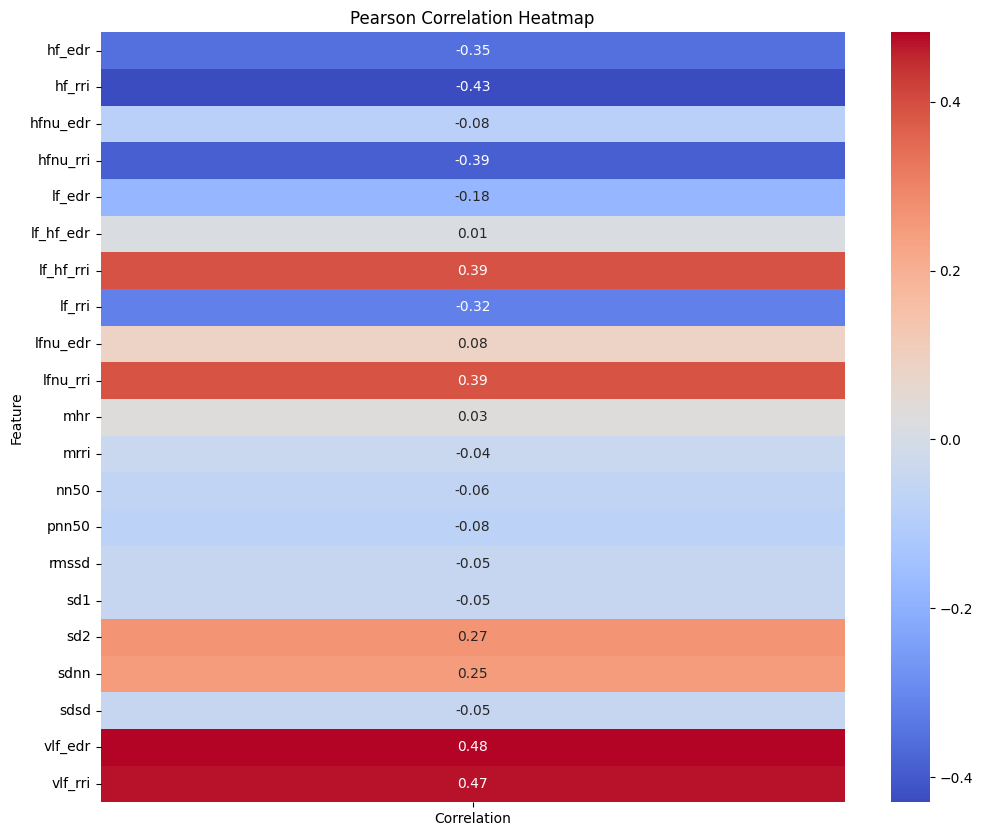

Pearson Correlation and P-value Results:
      Feature  Correlation        P-value
13    vlf_edr     0.482071   0.000000e+00
7     vlf_rri     0.469910   0.000000e+00
10  lf_hf_rri     0.392932   0.000000e+00
11   lfnu_rri     0.387690   0.000000e+00
20        sd2     0.265336  3.272591e-267
1        sdnn     0.248292  3.540298e-233
17   lfnu_edr     0.083527   2.922080e-27
6         mhr     0.030239   9.250799e-05
16  lf_hf_edr     0.012196   1.149151e-01
5        mrri    -0.036682   2.107150e-06
0       rmssd    -0.047445   8.470226e-10
19        sd1    -0.047485   8.195233e-10
3        sdsd    -0.047485   8.195233e-10
2        nn50    -0.061662   1.491074e-15
4       pnn50    -0.075761   1.056096e-22
18   hfnu_edr    -0.083527   2.922080e-27
14     lf_edr    -0.180238  5.274950e-122
8      lf_rri    -0.318374   0.000000e+00
15     hf_edr    -0.352370   0.000000e+00
12   hfnu_rri    -0.387690   0.000000e+00
9      hf_rri    -0.429510   0.000000e+00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr  # 피어슨 상관계수 계산을 위해 추가

# 데이터를 DataFrame으로 변환
data = train_df

# 피어슨 상관계수 계산 및 저장
correlation_results = []
p_values = []  # P-value를 저장하기 위한 리스트 추가
for feature in data.columns[1:-1]:  # 마지막 열은 호흡 상태
    corr, p_value = pearsonr(data[feature], data['label'])
    correlation_results.append((feature, corr))
    p_values.append(p_value)

# 결과를 DataFrame으로 변환
correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Correlation'])
correlation_df['P-value'] = p_values  # P-value 컬럼 추가

# 히트맵 그리기
plt.figure(figsize=(12, 10))
heatmap_data = correlation_df.pivot_table(index='Feature', columns=None, values='Correlation')
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Heatmap")
plt.show()

# 상관계수 및 P-value 결과 출력
print("Pearson Correlation and P-value Results:")
print(correlation_df.sort_values(by='Correlation', ascending=False))

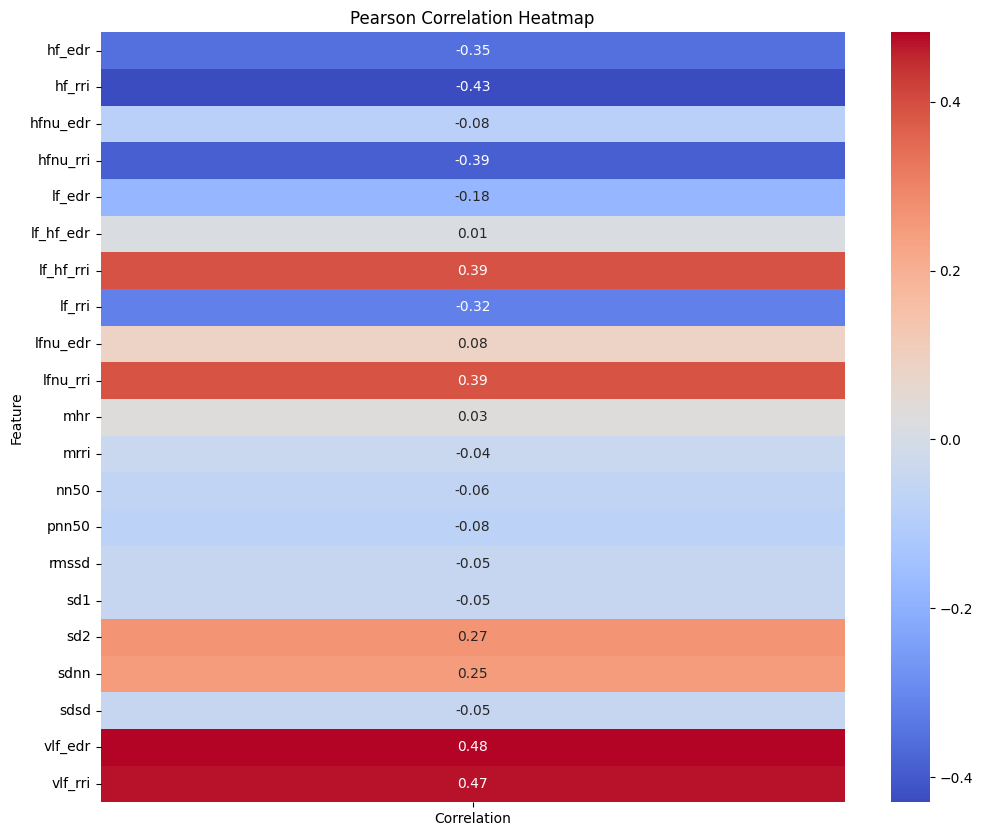

Pearson Correlation Results:
      Feature  Correlation
13    vlf_edr     0.482071
7     vlf_rri     0.469910
10  lf_hf_rri     0.392932
11   lfnu_rri     0.387690
20        sd2     0.265336
1        sdnn     0.248292
17   lfnu_edr     0.083527
6         mhr     0.030239
16  lf_hf_edr     0.012196
5        mrri    -0.036682
0       rmssd    -0.047445
19        sd1    -0.047485
3        sdsd    -0.047485
2        nn50    -0.061662
4       pnn50    -0.075761
18   hfnu_edr    -0.083527
14     lf_edr    -0.180238
8      lf_rri    -0.318374
15     hf_edr    -0.352370
12   hfnu_rri    -0.387690
9      hf_rri    -0.429510

VIF Results:
      Feature           VIF
0   intercept  0.000000e+00
1   lf_hf_edr  1.562985e+00
2   lf_hf_rri  2.656373e+00
3         mhr  5.774754e+01
4        mrri  7.092797e+01
5        nn50  1.432177e+02
6       pnn50  1.569350e+02
7         sd2  7.766065e+03
8        sdnn  8.737406e+03
9       rmssd  1.625017e+07
10        sd1           inf
11   hfnu_edr           inf

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터를 DataFrame으로 변환
data = train_df

# 피어슨 상관계수 계산 및 저장
correlation_results = []
for feature in data.columns[1:-1]:  # 마지막 열은 호흡 상태
    corr, _ = pearsonr(data[feature], data['label'])
    correlation_results.append((feature, corr))

# 결과를 DataFrame으로 변환
correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Correlation'])

# VIF 계산을 위한 데이터프레임 준비 (상수항 추가)
X = data.iloc[:, 1:-1]  # 마지막 열은 제외
X['intercept'] = 1

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 히트맵 그리기
plt.figure(figsize=(12, 10))
heatmap_data = correlation_df.pivot_table(index='Feature', columns=None, values='Correlation')
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Heatmap")
plt.show()

# 상관계수 결과 출력 및 VIF 결과 출력
print("Pearson Correlation Results:")
print(correlation_df.sort_values(by='Correlation', ascending=False))

print("\nVIF Results:")
print(vif_data.sort_values("VIF").reset_index(drop=True))

결과적으로, lf_hf_edr을 제외한 모든 변수가 유의함